# Toy Example for Dirichlet Diffusion Score Model 

In this notebook demo, we provide a quick demo on binarized MNIST dataset. Let's load required libraries first.

In [1]:
import tqdm.notebook

In [2]:
import os
from matplotlib import pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms


import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import tqdm


import pandas as pd
import functools
import numpy as np

# Main file which contrains all DDSM logic
from ddsm import * 

/home/zl6222/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/zl6222/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")


### Loading Presampled Noise

While Jacobi diffusion evaluation is more expensive than the commonly used diffusion process with Gaussian stationary distribution, all Jacobi diffusion-related computations can be precomputed prior to training and do not add to training time. This is feasible because we only need to generate samples from two starting points, 0 and 1, for any categorical data. Training time sampling is done by choosing randomly from the pre-sampled samples and scores. 

For presampling weights, you need to presample everything by running ''presample_noise.py'' script provided in the repo. For example,  
```
python presample_noise.py -n 10000 -c 2 -t 400 --out_path . --mode path
```
generates file with 2 categories, 10000 samples, and 400 timepoints. This noise will be used later for training, sampling, and computing negative log likelihood. 

Let's load generated file.

In [4]:
# !CUDA_VISIBLE_DEVICES="2" python presample_noise.py -n 10000 -c 2 -t 400 --out_path . --mode path

In [3]:
v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = torch.load("steps400.cat2.time4.0.samples10000.pth")
if torch.cuda.is_available():
    v_one = v_one.cuda()
    v_zero = v_zero.cuda()
    v_one_loggrad = v_one_loggrad.cuda()
    v_zero_loggrad = v_zero_loggrad.cuda()
    timepoints = timepoints.cuda()

# We have two categories, so the beta parameters are 
alpha = torch.DoubleTensor([1.0])
beta = torch.DoubleTensor([1.0])

# Example of 4 categories to be used with diffusion_factory
# alpha = torch.DoubleTensor([1.0, 1.0, 1.0])
# beta = torch.DoubleTensor([3.0, 2.0, 1.0])

### Defining the Model

Now, let's define the score-based model for binarized MNIST data. 

In [4]:
# Model architecture borrowed from https://github.com/yang-song/score_sde
# Note the manuscript experiment on binarized MNIST use a different, larger model

class Dense(nn.Module):
    """
    A fully connected layer that reshapes outputs to feature maps.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""
    def __init__(self, channels=[32, 64, 128, 256], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim),
        )
        
        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(2, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(
            channels[3], channels[2], 3, stride=2, bias=False
        )
        
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(
            channels[2] + channels[2],
            channels[1],
            3,
            stride=2,
            bias=False,
            output_padding=1,
        )
        
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(
            channels[1] + channels[1],
            channels[0],
            3,
            stride=2,
            bias=False,
            output_padding=1,
        )
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 2, 3, stride=1)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)

    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t / 4.0))
        # Encoding path
        h1 = self.conv1(x.permute(0, 3, 1, 2))
        ## Incorporate information from t
        h1 += self.dense1(embed)
        h1 = self.gnorm1(h1)
        h1 = self.act(h1)
        h2 = self.conv2(h1)
        h2 += self.dense2(embed)
        h2 = self.gnorm2(h2)
        h2 = self.act(h2)
        h3 = self.conv3(h2)
        h3 += self.dense3(embed)
        h3 = self.gnorm3(h3)
        h3 = self.act(h3)
        h4 = self.conv4(h3)
        h4 += self.dense4(embed)
        h4 = self.gnorm4(h4)
        h4 = self.act(h4)

        # Decoding path
        h = self.tconv4(h4)
        ## Skip connection from the encoding path
        h += self.dense5(embed)
        h = self.tgnorm4(h)
        h = self.act(h)
        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.tgnorm3(h)
        h = self.act(h)
        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.tgnorm2(h)
        h = self.act(h)
        h = self.tconv1(torch.cat([h, h1], dim=1))

        # some scaling here by time or x may be helpful but no scaling works fine here
        h = h.permute(0, 2, 3, 1)
        h = h - h.mean(axis=-1, keepdims=True)
        return h


### Loading Binarized Mnist Data 

The following code load MNIST data and create binarized version of it.

In [5]:
mkdir mnist

mkdir: cannot create directory ‘mnist’: File exists


In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import joblib
import numpy as np
from urllib.request import urlretrieve


def load_mnist_binarized(root):
    datapath = os.path.join(root, "bin-mnist")
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
            "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
            "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
            "binarized_mnist/binarized_mnist_test.amat",
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        joblib.dump(
            [datasplits["train"], datasplits["valid"], datasplits["test"]],
            open(dataset, "wb"),
        )

    x_train, x_valid, x_test = joblib.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device="cpu", transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device="cpu"):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    # x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return (
        BinMNIST(x_train, device=device),
        BinMNIST(x_valid, device=device),
        BinMNIST(x_test, device=device),
    )


def binary_to_onehot(x):
    xonehot = []
    xonehot.append((x == 1)[..., None])
    xonehot.append((x == 0)[..., None])
    return torch.cat(xonehot, -1)

train_set, valid_set, test_set = get_binmnist_datasets("./mnist")


Let's load training/validation/test datasets and dataset for importance sampling weights estimation. 

In [7]:
batch_size = 32

In [8]:
weights_est_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
training_dl = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [10]:
valid_data_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=0)
valid_datasets = []
for x in valid_data_loader:
    valid_datasets.append(x)

In [11]:
test_dl = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

### Global Parameters 

We define a few global parameters for our model

In [12]:
# number of categories are 2 for binarized MNIST data
C = 2  

# device, where code will be run
device = "cuda" # alternative option is "cpu"

# setting speed_balanced does not have an effect for C=2
# For >2 categories, setting speed_balanced flag affects the convergence speed of the forward diffusion. 
# (see Appendix A.2)
# speed_balanced = True leads to similar convergence speed across individual univariate Jacobi diffusion processes
# speed balanced = False leads to similar convergence speed across different categories after stick breaking transform

speed_balanced = False  

if speed_balanced:
    s = 2 / (
        torch.ones(C - 1, device=device)
        + torch.arange(C - 1, 0, -1, device=device).float()
    )
else:
    s = torch.ones(C - 1, device=device)
        
# Number of epochs for training
num_epochs = 50

Jacobi diffusion process converges to Beta stationary distribution, a univariate special case of Dirichlet distribution. Using the connection between Beta distribution and Dirichlet distribution, we construct a
multivariate diffusion process on probability simplex that converges to Dirichlet distribution with k − 1 independent univariate Jacobi diffusion processes by a classical stick- breaking construction (see Paragraph 3.2 for more details) 

In [13]:
sb = UnitStickBreakingTransform()

### Computing Importance Sampling Weights 

Importance sampling is often needed to stabilize the training of diffusion model with likelihood weighting, since the scores for the forward diffusion transition density functions are usually large when time is small. Importance sampling is thus used as a variance reduction technique that samples time non-uniformly during training. By sampling time points where the scale of the score is higher more often and down-weight the sample loss accordingly, the variance of the gradient can be reduced. We determine the importance sampling weight based on the scale of the scores at each time point observed empirically. The choice of using importance sampling or not or the form of importance sampling weights depends on your applications.

In [14]:
n_time_steps = timepoints.shape[0]

time_dependent_cums = torch.zeros(n_time_steps).to(device)
time_dependent_counts = torch.zeros(n_time_steps).to(device)

for i, x in enumerate(weights_est_dl):
    x = binary_to_onehot(x.squeeze())
    random_t = torch.randint(0, n_time_steps, (x.shape[0],))
    order = np.random.permutation(np.arange(C))
    
    # There are two options for using presampled noise: 
    # First one is regular approach and second one is fast sampling (see Appendix A.4 for more info)
    perturbed_x, perturbed_x_grad = diffusion_factory(
        x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta
    )
    # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)
    
    perturbed_x = perturbed_x.to(device)
    perturbed_x_grad = perturbed_x_grad.to(device)
    random_t = random_t.to(device)
    
    # Transform data from x space to v space, where diffusion happens
    order = np.random.permutation(np.arange(C))
    perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()

    # Computing score. gx_to_gv transforms gradient in x space to gradient in v space
    time_dependent_cums[random_t] += (
            (perturbed_v * (1 - perturbed_v)
                * s[(None,) * (x.ndim - 1)]
                * gx_to_gv(perturbed_x_grad, perturbed_x, compute_gradlogdet=False)** 2
            ).view(x.shape[0], -1).mean(dim=1).detach()
        )
        
    time_dependent_counts[random_t] += 1
    
time_dependent_weights = time_dependent_cums / time_dependent_counts
time_dependent_weights = time_dependent_weights / time_dependent_weights.mean()


The following plot verifies that our importance sampling weights are nice. It should be monotonic decreasing curve.

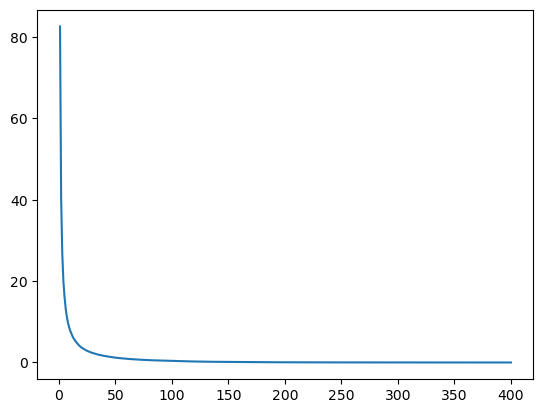

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, n_time_steps + 1), time_dependent_weights.cpu())

### Training

The following code trains the model and do validation check every 10 epochs.

In [16]:
#the score loss is computed in the v-space
def loss_fn(score, perturbed_x_grad, perturbed_x, important_sampling_weights=None):
    perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()
    if important_sampling_weights is not None:
        important_sampling_weights = 1/important_sampling_weights[
                    (...,) + (None,) * (x.ndim - 1)]
    else:
        important_sampling_weights = 1
    loss = torch.mean(
            torch.mean(
                important_sampling_weights
                * s[(None,) * (x.ndim - 1)]
                * perturbed_v * (1 - perturbed_v)
                * (gx_to_gv(
                        score, perturbed_x, create_graph=True, compute_gradlogdet=False
                    ) - gx_to_gv(perturbed_x_grad, perturbed_x, compute_gradlogdet=False)
                  ) ** 2,
                dim=(1))
        )
    return loss


In [17]:
torch.set_default_dtype(torch.float32)

# Defining a model
score_model = ScoreNet(channels=[64, 128, 256, 512], embed_dim=512)
score_model = score_model.to(device)
score_model.train()

# Defining optimizer
lr = 5e-4
optimizer = Adam(score_model.parameters(), lr=lr, weight_decay=1e-10)

timepoints = timepoints.cuda()

tqdm_epoch = tqdm.notebook.trange(num_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.0
    num_items = 0

    for x in training_dl:
        x = binary_to_onehot(x.squeeze())
        random_t = torch.LongTensor(
            np.random.choice(
                np.arange(n_time_steps),
                size=x.shape[0],
                p=(
                    torch.sqrt(time_dependent_weights)
                    / torch.sqrt(time_dependent_weights).sum()
                )
                .cpu()
                .detach()
                .numpy(),
            )
        ).to(device)
        
        # Similarly to computing importance sampling weights, there are two options 
        perturbed_x, perturbed_x_grad = diffusion_factory(
            x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta
        )
        # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)
        
        perturbed_x = perturbed_x.to(device)
        perturbed_x_grad = perturbed_x_grad.to(device)
        random_t = random_t.to(device)
        random_timepoints = timepoints[random_t]
        
        # Doing score estimation via neural network
        score = score_model(perturbed_x, random_timepoints)
        
        # Computing loss function
        loss = loss_fn(score, perturbed_x_grad, perturbed_x, 
                       important_sampling_weights=(torch.sqrt(time_dependent_weights))[random_t])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Print the averaged training loss so far.
    tqdm_epoch.set_description("Average Loss: {:5f}".format(avg_loss / num_items))

    # Doing validation check every 10 epochs.
    if epoch % 10 == 0:
        valid_avg_loss = 0.0
        valid_num_items = 0
        
        for x in valid_datasets:
            
            x = binary_to_onehot(x.squeeze())
            random_t = torch.LongTensor(
                np.random.choice(
                    np.arange(n_time_steps),
                    size=x.shape[0],
                    p=(
                        torch.sqrt(time_dependent_weights)
                        / torch.sqrt(time_dependent_weights).sum()
                    ).cpu().detach().numpy(),
                )
            ).to(device)
            
            perturbed_x, perturbed_x_grad = diffusion_factory(
                x, random_t, v_one, v_zero, v_one_loggrad, v_zero_loggrad, alpha, beta
            )
            # perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)
            
            perturbed_x = perturbed_x.to(device)
            perturbed_x_grad = perturbed_x_grad.to(device)
            random_t = random_t.to(device)
            random_timepoints = timepoints[random_t]

            score = score_model(perturbed_x, random_timepoints)            
            loss = loss_fn(score, perturbed_x_grad, perturbed_x, 
                       important_sampling_weights=(torch.sqrt(time_dependent_weights))[random_t])

            valid_avg_loss += loss.item() * x.shape[0]
            valid_num_items += x.shape[0]

        print("Average Loss: {:5f}".format(valid_avg_loss / valid_num_items))


  0%|          | 0/50 [00:00<?, ?it/s]

Average Loss: 0.369046
Average Loss: 0.132611
Average Loss: 0.122615
Average Loss: 0.120690
Average Loss: 0.118527


### Sampling Examples from Dataset. 

Let's sample a few examples from the model by using simple Euler-Maruyama sampler. 

In [30]:
samples[0][0].clamp(0.0,1.0)

tensor([[1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01]], device='cuda:0')

In [31]:
samples[0][0]

tensor([[1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9747e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9748e-02, 9.8025e-01],
        [1.9747e-02, 9.8025e-01],
        [1.0000e-05, 9.9999e-01]], device='cuda:0')

In [26]:
torch.min(samples[0]), torch.max(samples[0])

(tensor(1.0000e-05, device='cuda:0'), tensor(1.0000, device='cuda:0'))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 363.02it/s]


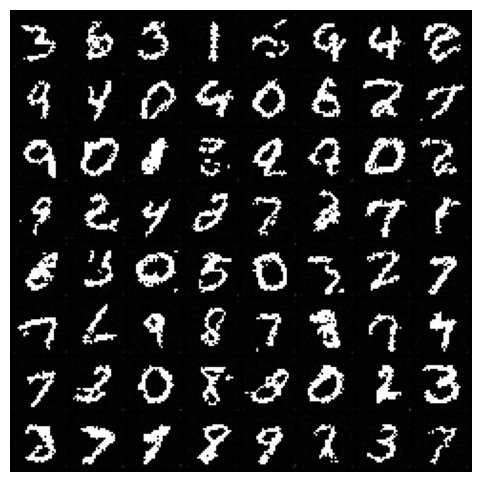

In [18]:
#### Comments #####
# the output of the model is not binary
# generate samples from trained model
torch.set_default_dtype(torch.float32)
score_model.eval()

device = 'cuda' 

sample_batch_size = 64 
sampler = Euler_Maruyama_sampler ## Generate samples using the specified sampler.

samples = sampler(score_model, (28, 28, 2),
                        batch_size=sample_batch_size,
                        max_time= 4,
                        min_time=0.01, 
                        num_steps=100, 
                        eps=1e-5,
                        device=device)

samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples[:,None, :,:,0].detach().cpu(), nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

We also propose technique called **time dialation** to improve sample quality (see Appendix A.5 and B.9). 

Comparing to unbiasedly sample from the learned model distribution, it is often desirable to sample near the high probability density regions, which often corresponds to higher quality samples in suitable application. Time dilation is applicable to reverse diffusion sampling without modifying the score model, when a flat distribution such as the flat Dirichlet distribution is the stationary distribution. Our sampler implementation support time dilation technique out-of-box.  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 384.24it/s]


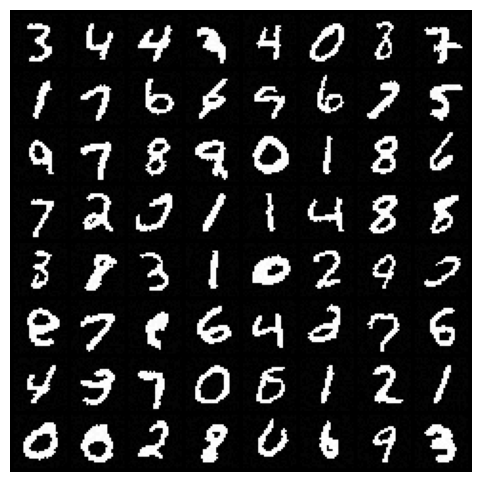

In [19]:
#generate samples with time dilation

samples = sampler(score_model,
                        (28,28,2),
                        batch_size=sample_batch_size,
                        max_time= 4,
                        min_time=0.01,
                        num_steps=100,
                        time_dilation=8,
                        time_dilation_start_time=1,
                        eps=1e-5,
                        device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
sample_grid = make_grid(samples[:,None, :,:,0].detach().cpu(), nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

### Computing Negative Log Likelihood (ELBO) in Discrete Space

We can estimate likelihood using probability flow ODE. Our formulation allows both computing the likelihood from
the continuous distribution over the simplex, and computing a variation lower-bound of the likelihood of discrete data. The ELBO formulation is chosen so that the diffusion model training will also minimize the variational gap of this ELBO, which reduces to the KL divergence between the forward diffusion density and the reverse diffusion density up to a constant when minimum time is close to zero. The following code estimates ELBO based on test data. 

In [20]:
# compute NLL (ELBO) in discrete space
diffusion_factory_fn = lambda x, time_inds : diffusion_factory(x, time_inds, v_one, v_zero,
                                        v_one_loggrad, v_zero_loggrad, alpha, beta)

def ELBO(x, score_model, diffusion_factory_fn, min_time, max_time, device="cuda", elbo_only=True):
    perturbed_x, _ = diffusion_factory_fn(x.cpu(), torch.zeros(x.shape[0]).long())
    perturbed_x = perturbed_x.to(device)
    x = x.to(device)
    v = sb._inverse(x, prevent_nan=False)
    perturbed_v = sb._inverse(perturbed_x, prevent_nan=False)

    z, loglik = ode_likelihood(
        perturbed_v, score_model,
        eps=1e-5, min_time=min_time, max_time=max_time, device=device,
        alpha=None, beta=None, speed_balanced=speed_balanced)
    N = np.prod(x.shape[1:-1])
    loglik = loglik / N

    loglikx = (torch.log(perturbed_x) * (x == 1)).sum(-1).mean()

    torch.set_default_dtype(torch.float64)

    qlog = jacobi_diffusion_density(
        v.double(), perturbed_v.double(), min_time,
        alpha.to(device), beta.to(device),
        order=1000,
        speed_balanced=speed_balanced,
    ).log()
    
    for i, (a, b) in enumerate(zip(alpha.to(device), beta.to(device))):
        B = Beta(a, b)
        nanmask = torch.isnan(qlog[..., i])
        qlog[..., i][nanmask] = B.log_prob(perturbed_v[..., i][nanmask].double())
        
    qlog = (qlog.sum(-1) + sb.log_abs_det_jacobian(perturbed_v)).mean().float()
    torch.set_default_dtype(torch.float32)

    elbo = loglik + loglikx - qlog
    if elbo_only:
        return elbo
    else:
        return elbo, loglik, loglikx, qlog
    

In [21]:
score_model.cuda()
score_model.eval()

all_bpds = 0.0
all_items = 0
min_time = timepoints[0].item()
max_time = timepoints[-1].item()



# note that as the NLL estimate used the stochastic Huchinson's trace estimator
# it generally requires multiple passes to obtain a stable estimate
for x in test_dl:
    x = binary_to_onehot(x).squeeze()
    
    elbo = ELBO(x, score_model, diffusion_factory_fn, min_time, max_time)
    bpd = -(elbo.cpu().detach().numpy()) / np.log(2)
    all_bpds += bpd.sum()
    all_items += bpd.shape[0]
    print("Average bits: {:5f}".format(all_bpds / all_items))
    print("Average nats: {:5f}".format(all_bpds / all_items * np.log(2)))


Number of function evaluations: 266
Average bits: 0.166889
Average nats: 0.115679
Number of function evaluations: 269
Average bits: 0.179123
Average nats: 0.124159
Number of function evaluations: 248
Average bits: 0.160486
Average nats: 0.111241
Number of function evaluations: 269
Average bits: 0.164685
Average nats: 0.114151
Number of function evaluations: 272
Average bits: 0.178239
Average nats: 0.123546
Number of function evaluations: 257
Average bits: 0.184981
Average nats: 0.128219
Number of function evaluations: 257
Average bits: 0.184087
Average nats: 0.127599
Number of function evaluations: 272
Average bits: 0.183992
Average nats: 0.127534
Number of function evaluations: 269
Average bits: 0.192342
Average nats: 0.133321
Number of function evaluations: 263
Average bits: 0.191723
Average nats: 0.132892
Number of function evaluations: 272
Average bits: 0.188620
Average nats: 0.130742
Number of function evaluations: 263
Average bits: 0.187919
Average nats: 0.130255
Number of functi